In [310]:
import pandas as pd
import plotly.express as px
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

# Introduction

This is the final project for **Introduction to Machine Learning: Supervised Learning**.

Data source: https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation

The goal of this project is to utilize the data about coupon acceptance of drivers. Based on different conditions, will the driver accept the coupon from Amazon? (Yes or No). Therefore it is a classification problem. I would like to study what is the underlying reason to attract drivers to make such decision.

"This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper:
Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393."


## 1. EDA


In [311]:
# Import data
df = pd.read_csv("in-vehicle-coupon-recommendation.csv", delimiter=",")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [312]:
# List out all features and their summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

Based on above, y is the dependent variable. We need to explore the other features first.

Many features are in string form, if they are needed for further analysis they need to be transformed.


## 2. Data Cleaning and Transformation


In [313]:
# Check for null values
for col in df.columns:
    empty_count = df[col].isna().sum()
    if empty_count > 0:
        print(col, empty_count, empty_count/len(df))

car 12576 0.9914853358561968
Bar 107 0.008435824660990224
CoffeeHouse 217 0.017108167770419427
CarryAway 151 0.011904761904761904
RestaurantLessThan20 130 0.010249132765689057
Restaurant20To50 189 0.014900662251655629


In [314]:
# Considering high null count on car col, dropping
df = df.drop(columns=['car'])
# Fill mode of the others as their nulls are immaterial
for col in df.columns:
    empty_count = df[col].isna().sum()
    if empty_count > 0:
        df[col].fillna(df[col].mode(), inplace=True)

/tmp/ipykernel_31661/17882858.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [315]:
# String type column
for col in df.columns:
    if df[col].dtype == object:
        print(col, df[col].unique())

destination ['No Urgent Place' 'Home' 'Work']
passanger ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather ['Sunny' 'Rainy' 'Snowy']
time ['2PM' '10AM' '6PM' '7AM' '10PM']
coupon ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration ['1d' '2h']
gender ['Female' 'Male']
age ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
education ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Personal Care & Service'
 'Community & Social Services' 'Office & Administrative Support'
 'Constr

In [316]:
# Numeric/Boolean type columns
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [317]:
# toCoupon_GEQ5min are all 1, dropping
df = df.drop(columns=["toCoupon_GEQ5min"])

## Visualization for categorical features


In [318]:
px.histogram(df["destination"], width=500, title="Destination Count")

In [319]:
px.histogram(df["passanger"], width=500, title="Passenger Count")

In [320]:
px.histogram(df["occupation"], width=500, title="Occupation Count")

From the observation we can see that features like destination and passenger type has less unique values, while occupation type has many. Passenger count has highly biased toward the "alone" type as well.


## Correlation analysis between features

Require transformation of features from str to int


In [321]:
dtypes = df.dtypes
columns = df.columns
for x in columns:
    if dtypes[x] == object:
        print(x, df[x].unique())
        le = preprocessing.LabelEncoder()
        le.fit(df[x].unique())
        df[x] = le.transform(df[x])
        print(x, df[x].unique())

destination ['No Urgent Place' 'Home' 'Work']
destination [1 0 2]
passanger ['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
passanger [0 1 2 3]
weather ['Sunny' 'Rainy' 'Snowy']
weather [2 0 1]
time ['2PM' '10AM' '6PM' '7AM' '10PM']
time [2 0 3 4 1]
coupon ['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
coupon [4 2 1 0 3]
expiration ['1d' '2h']
expiration [0 1]
gender ['Female' 'Male']
gender [0 1]
age ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
age [0 5 1 2 4 6 3 7]
maritalStatus ['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
maritalStatus [3 2 1 0 4]
education ['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
education [5 1 0 3 2 4]
occupation ['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts 

In [322]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   destination           12684 non-null  int64
 1   passanger             12684 non-null  int64
 2   weather               12684 non-null  int64
 3   temperature           12684 non-null  int64
 4   time                  12684 non-null  int64
 5   coupon                12684 non-null  int64
 6   expiration            12684 non-null  int64
 7   gender                12684 non-null  int64
 8   age                   12684 non-null  int64
 9   maritalStatus         12684 non-null  int64
 10  has_children          12684 non-null  int64
 11  education             12684 non-null  int64
 12  occupation            12684 non-null  int64
 13  income                12684 non-null  int64
 14  Bar                   12684 non-null  int64
 15  CoffeeHouse           12684 non-null  int64
 16  Carr

Y                    1.000000
weather              0.098800
coupon               0.097019
temperature          0.061240
passanger            0.051614
Restaurant20To50    -0.055503
Bar                 -0.076136
toCoupon_GEQ15min   -0.081602
toCoupon_GEQ25min   -0.103633
expiration          -0.129920
CoffeeHouse         -0.143538
Name: Y, dtype: float64

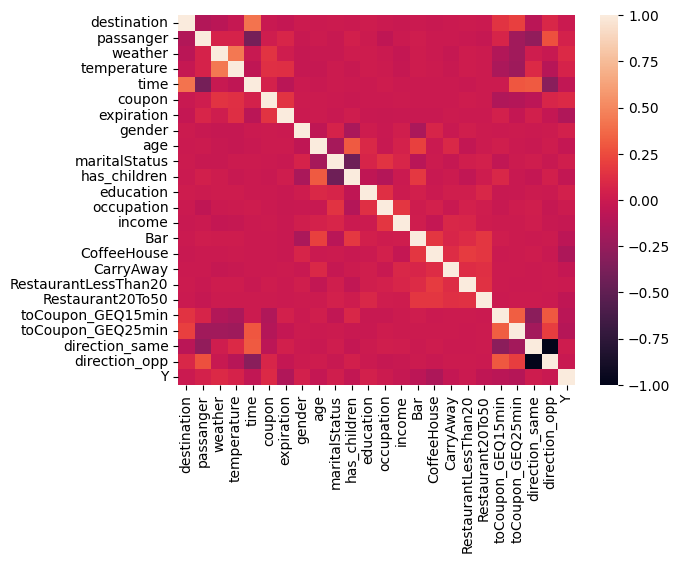

In [323]:
sns.heatmap(df.corr())
correlation = df.corr()['Y']
correlation[(correlation>0.05)|(correlation<-0.05)].sort_values(ascending=False)

No single features has high correlation with Y.


# 3. Training model

We are using Decision Tree classifier due to the fact that:

1. We can feed features without consider scaling;
2. Easy to interpret; to achieve our goal that to understand the underlying reason of attracting drivers


In [324]:
# Split dataset
X = df.drop(columns='Y')
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [325]:
# Training with raw param
classifier = DecisionTreeClassifier(max_depth=10, random_state=0)
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
accuracy_score(y_true=y_test, y_pred = pred)

0.6988569176192353

In [326]:
# Try to improve using hyperparameter tuning
params = {
            'max_depth' : np.arange(3,10),
            'criterion': ['gini', 'entropy'],
            'max_leaf_nodes' : [5,10,15,20,50],
            'min_samples_split' : [2,4,5,10]
}
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), params, scoring="accuracy")
grid_search_tree.fit(X_train, y_train)
print(grid_search_tree.best_estimator_)
grid_search_tree.best_score_

DecisionTreeClassifier(max_depth=8, max_leaf_nodes=50)


0.7075986860473866

In [327]:
best_model = grid_search_tree.best_estimator_
y_pred = best_model.predict(X_test)
acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)
f_score = f1_score(y_true=y_test, y_pred=pred)
acc_score, f_score

(0.696491919590067, 0.7403127124405167)

With parameter tuning, we only improve slightly on accuracy.
Now we look at feature importance.

In [328]:
features = X.columns
scores = best_model.feature_importances_.tolist()
feature_importance = pd.DataFrame({'features': features, 'score': scores})
feature_importance = feature_importance.sort_values(by='score', ascending=False)
print(feature_importance)

                features     score
5                 coupon  0.371371
14                   Bar  0.128727
15           CoffeeHouse  0.125952
6             expiration  0.083903
20     toCoupon_GEQ25min  0.073099
4                   time  0.049894
21        direction_same  0.026633
2                weather  0.019439
12            occupation  0.017165
17  RestaurantLessThan20  0.016364
13                income  0.015882
0            destination  0.012879
11             education  0.010149
7                 gender  0.009637
19     toCoupon_GEQ15min  0.006734
1              passanger  0.006506
10          has_children  0.005924
8                    age  0.005442
18      Restaurant20To50  0.004934
9          maritalStatus  0.004716
3            temperature  0.004650
16             CarryAway  0.000000
22         direction_opp  0.000000


In [329]:
# What if we choose features with importance > 5% only
special_features = list(feature_importance[feature_importance["score"]>0.05]["features"])
special_features

['coupon', 'Bar', 'CoffeeHouse', 'expiration', 'toCoupon_GEQ25min']

In [330]:
classifier = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=50)
classifier.fit(X_train[special_features], y_train)
pred = classifier.predict(X_test[special_features])
accuracy_score(y_true=y_test, y_pred=pred), f1_score(y_true=y_test, y_pred=pred)


(0.6819077650768625, 0.729103726082578)

The accuracy didn't increase as we remove most features with lower importance.

## More evaluation on model

In [331]:
confusion_matrix(y_test, pred)

array([[ 644,  467],
       [ 340, 1086]])

In [332]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61      1111
           1       0.70      0.76      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.68      0.67      0.67      2537
weighted avg       0.68      0.68      0.68      2537



As we can see the recall score for negative is not that satisfactory, f1-score the negative is also low. Therefore, we adjust our grid search CV to focus on f1 score instead.

In [333]:
# Try to improve using hyperparameter tuning
params = {
            'max_depth' : np.arange(3,10),
            'criterion': ['gini', 'entropy'],
            'max_leaf_nodes' : [5,10,15,20,50],
            'min_samples_split' : [2,4,5,10]
}
grid_search_tree = GridSearchCV(DecisionTreeClassifier(), params, scoring="f1")
grid_search_tree.fit(X_train, y_train)
print(grid_search_tree.best_estimator_)
grid_search_tree.best_score_

DecisionTreeClassifier(max_depth=9, max_leaf_nodes=50)


0.7571887790354503

In [334]:
best_model = grid_search_tree.best_estimator_
y_pred = best_model.predict(X_test)
acc_score = accuracy_score(y_true=y_test, y_pred=y_pred)
f_score = f1_score(y_true=y_test, y_pred=pred)
acc_score, f_score

(0.6972802522664564, 0.729103726082578)

In [335]:
features = X.columns
scores = best_model.feature_importances_.tolist()
feature_importance = pd.DataFrame({'features': features, 'score': scores})
feature_importance = feature_importance.sort_values(by='score', ascending=False)
print(feature_importance)

                features     score
5                 coupon  0.370707
15           CoffeeHouse  0.130713
14                   Bar  0.128497
6             expiration  0.083752
20     toCoupon_GEQ25min  0.072968
4                   time  0.049805
2                weather  0.019404
12            occupation  0.017134
17  RestaurantLessThan20  0.016334
21        direction_same  0.013689
22         direction_opp  0.012897
0            destination  0.012856
13                income  0.011469
8                    age  0.010614
7                 gender  0.009620
19     toCoupon_GEQ15min  0.006722
1              passanger  0.006494
11             education  0.006136
10          has_children  0.005913
18      Restaurant20To50  0.004925
9          maritalStatus  0.004707
3            temperature  0.004641
16             CarryAway  0.000000


In [336]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61      1111
           1       0.70      0.76      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.68      0.67      0.67      2537
weighted avg       0.68      0.68      0.68      2537



In [337]:
# What if we choose features with importance > 5% only
special_features = list(feature_importance[feature_importance["score"]>0.05]["features"])
classifier = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=50)
classifier.fit(X_train[special_features], y_train)
pred = classifier.predict(X_test[special_features])
accuracy_score(y_true=y_test, y_pred=pred), f1_score(y_true=y_test, y_pred=pred)


(0.6819077650768625, 0.729103726082578)

In [338]:
confusion_matrix(y_test, pred)

array([[ 644,  467],
       [ 340, 1086]])

In [339]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61      1111
           1       0.70      0.76      0.73      1426

    accuracy                           0.68      2537
   macro avg       0.68      0.67      0.67      2537
weighted avg       0.68      0.68      0.68      2537



Compare with the previous model, this model has a higher true negative rate.

## Conclusion

This study try to find out the most influential factor for a driver to get coupon. In the end, the feature importance told us that the *coupon type* is most key factors, followed by have they visited bar or coffeeHouse before (and their frequency)
The simple decision tree model helps solve this problem and at the end the accuracy is quite satisfactory.

However, the model can be improved by using other supervised learning method like neural network.